In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import sys
sys.path.append('/home/esther/qr_for_landcover/scripts')
import landcover_definitions as lc
import util
import pickle

sys.path.append('../evaluation')
import run_model_forward_and_produce_tifs as run_model

In [2]:
torchgeo_data_dir = '/datadrive/esther/torchgeo_data'
torchgeo_preds_dir = '/home/esther/torchgeo_predictions_rep'
torchgeo_output_dir = '/home/esther/qr_for_landcover/output_rep'


In [3]:
def reindex_cc(array_in):
    impervious_idxs_highres_orig = [4,5,6]
    impervious_idx_condensed = 4
    
    reindexed_array = array_in.copy()
    for c_idx in impervious_idxs_highres_orig:
        reindexed_array[array_in == c_idx] = impervious_idx_condensed
            
    return reindexed_array - 1

ignore_index = 4

In [12]:
set_this = 'test'
compute_r = True
results_by_state_q = {}
results_by_state_r = {}

states_to_eval = ['ny+pa',
                  'ny', 
                  'pa'
                 ]

states_to_statename = {
    'ny':'ny_1m_2013',
    'pa':'pa_1m_2013'
}

loss_to_eval_options = ['qr_forward', 
                        'qr_reverse'
                       ]
                        

prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4
lc_type = 'chesapeake_4_no_zeros'
compute_r = True

for loss in loss_to_eval_options:
    results_by_state_q[loss] = {}
    results_by_state_r[loss] = {}
    
    for state_str in states_to_eval:

        data_dir = f'{torchgeo_data_dir}/cvpr_chesapeake_landcover'
        model_ckpt_dir = f'{torchgeo_output_dir}/chesapeake_north_qr'
        run_name = f'{state_str}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'
               
        accs_q = []
        ious_q = []
        accs_r = []
        ious_r = []
        num_pix = []
        
        for state in state_str.split('+'):
            state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
            data_dir_this_set = os.path.join(data_dir,state_identifier)
            pred_dir = f'{torchgeo_preds_dir}/{run_name}/cvpr_chesapeake_landcover'
            pred_dir_this_set = os.path.join(pred_dir,state_identifier)
        
            fns = os.listdir(data_dir_this_set)
            tile_ids = np.unique([x[:17] for x in fns])
            
            print(len(tile_ids))
            
            for tile_id in tile_ids:
                fn_this = os.path.join(data_dir_this_set, f'{tile_id}_lc.tif')
                image_fn = os.path.join(torchgeo_data_dir, 
                                    'cvpr_chesapeake_landcover', 
                                    f'{states_to_statename[state]}_extended-debuffered-test_tiles',
                                    f'{tile_id}_naip-new.tif')
                
                t1 = time.time()
                
                model_ckpt_fp = os.path.join(model_ckpt_dir, run_name, 'last.ckpt')
                preds_this_soft = run_model.run_through_tiles(model_ckpt_fp,
                                             input_fns=[image_fn],
                                             output_fns= [''],
                                             model_kwargs = {'in_channels': 4, 
                                                             'classes': 4, 
                                                             'output_smooth':1e-4,
                                                             'num_filters': 128},
                                             return_dont_save=True,
                                                             gpu=1,)
                
                preds_this = preds_this_soft.argmax(0)

                # gather the data
                with rasterio.open(fn_this) as f:
                    hr_lc = f.read()[0]
                # reindex
                hr_lc = reindex_cc(hr_lc)

                acc_this_q = (np.array([hr_lc == preds_this])[np.array([hr_lc!=ignore_index])]).mean()

                # ignore 0
                iou_this_q = util.per_class_iou(hr_lc, preds_this, np.arange(0,ignore_index))
                accs_q.append(acc_this_q)
                ious_q.append(iou_this_q)
                num_pix.append((hr_lc != ignore_index).sum())

                if compute_r:
                    # now do r
                    prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()

                    # first normalize
                    prior = prior_this / prior_this.sum(axis=0)
                    # now add smoothing and renormalize 

                    prior = (prior + p_add_smooth) / (prior + p_add_smooth).sum(axis=0)

                    # compute z and r
                    z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                    preds_r = (prior*z).argmax(0)

                    acc_this_r = (np.array([hr_lc == preds_r])[np.array([hr_lc!=ignore_index])]).mean()
                    iou_this_r = util.per_class_iou(hr_lc, preds_r, np.arange(0,ignore_index))

                    accs_r.append(acc_this_r)
                    ious_r.append(iou_this_r)

                t2 = time.time()
                print(f'{t2-t1:.2f} seconds')

        ious_aggregated_q = util.aggregate_ious([x[1] for x in ious_q], [x[2] for x in ious_q])
        acc_aggregated_q = (np.array(accs_q) * np.array(num_pix)).sum() / np.sum(num_pix)
        print(f'For {state_str} {set_this} set with {loss} loss:')
        print(f'acc q: {acc_aggregated_q}')
        print(f'mean iou q: {np.mean(ious_aggregated_q[0])}')
        
        if compute_r:
            acc_aggregated_r = (np.array(accs_r) * np.array(num_pix)).sum() / np.sum(num_pix)
            ious_aggregated_r = util.aggregate_ious([x[1] for x in ious_r], [x[2] for x in ious_r])
            print(f'acc r: {acc_aggregated_r}')
            print(f'mean iou r: {np.mean(ious_aggregated_r[0])}')
        
        print('IoU per class over the tiles (q) is: ')
        print(ious_aggregated_q[0])
        if compute_r:
            print('IoU per class over the tiles (r) is: ')
            print(ious_aggregated_r[0])
        

        results_by_state_q[loss][state_str] = {'accs': accs_q,
                                           'ious': ious_q,
                                           'num_pix':num_pix,
                                           'ious_aggregated': ious_aggregated_q,
                                           'acc_aggregated':acc_aggregated_q}
        
        if compute_r:
            results_by_state_r[loss][state_str] = {'accs': accs_r,
                                               'ious': ious_r,
                                               'num_pix':num_pix,
                                               'ious_aggregated': ious_aggregated_r,
                                               'acc_aggregated':acc_aggregated_r}
        


20
0 of 1
9.82 seconds
0 of 1
9.68 seconds
0 of 1
9.50 seconds
0 of 1
9.58 seconds
0 of 1
9.48 seconds
0 of 1
9.50 seconds
0 of 1
9.58 seconds
0 of 1
9.53 seconds
0 of 1
9.49 seconds
0 of 1
9.41 seconds
0 of 1
9.51 seconds
0 of 1
9.79 seconds
0 of 1
9.61 seconds
0 of 1
9.74 seconds
0 of 1
9.73 seconds
0 of 1
10.27 seconds
0 of 1
9.89 seconds
0 of 1
9.74 seconds
0 of 1
9.95 seconds
0 of 1
10.23 seconds
20
0 of 1
10.44 seconds
0 of 1
10.49 seconds
0 of 1
10.35 seconds
0 of 1
10.17 seconds
0 of 1
9.97 seconds
0 of 1
10.44 seconds
0 of 1
10.36 seconds
0 of 1
10.27 seconds
0 of 1
10.05 seconds
0 of 1
9.63 seconds
0 of 1
9.91 seconds
0 of 1
9.84 seconds
0 of 1
9.85 seconds
0 of 1
10.20 seconds
0 of 1
10.00 seconds
0 of 1
10.16 seconds
0 of 1
10.64 seconds
0 of 1
10.30 seconds
0 of 1
10.09 seconds
0 of 1
10.20 seconds
For ny+pa test set with qr_forward loss:
acc q: 0.8599813605754073
mean iou q: 0.7032299041490928
acc r: 0.8661815272844173
mean iou r: 0.7192817428380072
IoU per class over the

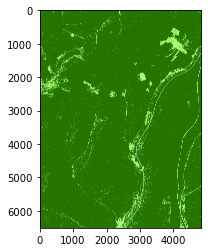

In [12]:
# visualize an example of the predictions
plt.imshow(lc.vis_lc(preds_this_soft,lc_type).T.swapaxes(0,1))

# compile in table format

In [14]:
states_in_reporting_order = [
    'pa', 
    'ny', 
    'ny+pa']

for loss in ['qr_forward','qr_reverse']:
    print(loss + " q ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_q = results_by_state_q[loss][state]
        
        result_str += f"& {np.round(results_q['acc_aggregated']*100,1):.01f} "
        result_str += f"& {np.round(np.mean(results_q['ious_aggregated'][0])*100,1):.01f} "
        
    print(result_str)
    
    print(loss + " r ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_r = results_by_state_r[loss][state]
        
        result_str += f"& {np.round(results_r['acc_aggregated']*100,1):.01f}  "
        result_str += f"& {np.round(np.mean(results_r['ious_aggregated'][0])*100,1):.01f} "
        
    print(result_str)
    

qr_forward q 
& 85.5 & 68.7 & 87.3 & 73.4 & 86.0 & 70.3 
qr_forward r 
& 85.9  & 69.4 & 88.0  & 74.7 & 86.6  & 71.9 
qr_reverse q 
& 75.8 & 32.7 & 77.1 & 59.8 & 79.2 & 61.9 
qr_reverse r 
& 76.8  & 46.5 & 77.1  & 59.9 & 79.2  & 62.2 
